In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import MolFromSmiles, MACCSkeys
rdDepictor.SetPreferCoordGen(True)
# sns.set_context('notebook')
# sns.set_style('white',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#F06060', '#1BBC9B', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

In [2]:
# scramble them
# Reduced for CI!
# soldata = soldata.sample(frac=0.01, random_state=0).reset_index(drop=False)
# soldata.head()

In [3]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]
len(selfies_list)

9982

In [4]:
vocab = list(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab_stoi = {o:i for o,i in zip(vocab, range(1, len(vocab)+1))}
vocab_stoi['[nop]'] = 0
print('Vocab size', len(vocab))

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result
def ints2selfies(v):
    return ''.join([vocab[i-1] for i in v])

# test them out
s = selfies_list[1]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s

Vocab size 206
selfies: [O][=C][N][C][=C][C][=C][C][=C][C][=C][C][Ring1][O][=C][Ring1][Branch2_3][Ring1][Branch1_2]
selfies2ints: [157, 36, 188, 190, 36, 190, 36, 190, 36, 190, 36, 190, 164, 157, 36, 164, 52, 164, 127]
ints2selfes: [O][=C][N][C][=C][C][=C][C][=C][C][=C][C][Ring1][O][=C][Ring1][Branch2_3][Ring1][Branch1_2]


In [5]:
#creating an object
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int
        
config = Config(vocab_size=len(vocab) + 1, 
                example_number=len(selfies_list), 
                batch_size=16, 
                buffer_size=10000, 
                embedding_dim=256, 
                hidden_dim=128,
                rnn_units=128)

In [6]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post', value=vocab_stoi['[nop]'])

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values))
# now split into val, test, train and batch
N = len(data)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         52992     
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 217,857
Trainable params: 217,857
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=0)

In [9]:
model.save('solubility-rnn-accurate')
# model = tf.keras.models.load_model('solubility-rnn-accurate/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: solubility-rnn-accurate/assets


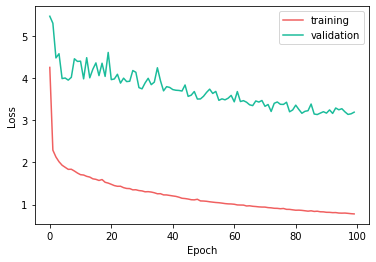

In [10]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# plt.savefig('rnn-loss.png', bbox_inches="tight", dpi=180)

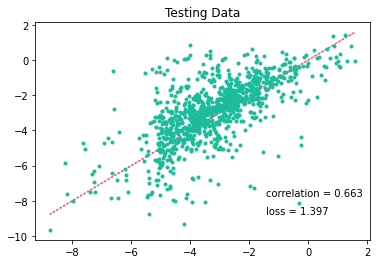

In [11]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(max(test_y) - 3, min(test_y) + 1, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(max(test_y) - 3, min(test_y), f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
# plt.savefig('rnn-fit.png', dpi=300)
plt.show()


## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [12]:
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [13]:
def calc_ft_imp(space, space_tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats) if abs(b) > 2.96}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

In [14]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
def plot_space_with_desc(feature_importance, space, desc_type, output_file='file1.png'):
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 12}

    fig = plt.figure(figsize=(12,5))
    # ax_dict = fig.subplot_mosaic('BBBAA')
    ax_dict = fig.subplot_mosaic('AAABBB')

    r = Rectangle((0, 0), 1, 1)
    # cmap = plt.get_cmap("gist_rainbow", 20)
    # colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    # bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
    bar1 = ax_dict['A'].barh(range(len(t)), t, color=colors, height=0.75)
    new_patches = []
    for patch in reversed(ax_dict['A'].patches):
        bb = patch.get_bbox()
        color=patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.040,rounding_size=0.015",
                            ec="none", fc=color,
                            mutation_aspect=4
                            )
        patch.remove()
        new_patches.append(p_bbox)
    for patch in new_patches:
        ax_dict['A'].add_patch(patch)

    count = 1
    for rect, ti, k in zip(bar1, t, keys):
        y = rect.get_y() + rect.get_height()/2.
        if len(k) > 60:
            k = textwrap.fill(k, 30)
        elif len(k) > 30:
            k = textwrap.fill(k, 25)
        if ti < 0:
            x = 0.5
            ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
            count+=1
        else:
            x = -1.0 #.5
            ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
            count+=1


    ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
    ax_dict['A'].invert_yaxis()
    ax_dict['A'].set_xlabel('Feature t-statistics')
    # ax_dict['A'].get_yaxis().set_ticks([])
    svg = exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B']) #, cartoon=True)
    # plt.colorbar(location='left', label='Solubility [Log M]')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
#     if desc_type=='MACCS':
#         plt.savefig('no_significance_maccs2.svg', dpi=300, bbox_inches='tight')
#     if desc_type=='Classic':
#         plt.savefig('no_significance_classic2.svg', dpi=300, bbox_inches='tight')

In [15]:
def plot_desc(feature_importance, desc_type, output_file, title=None, ax = None):
    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    if len(t) > 0:
        if len(t) > 5:
            t = t[:5]
            keys = keys[:5]
            print(t)
        elif len(t) < 5:
            diff = 5 - len(t)
            for i in range(diff):
                t.append(0)
                keys.append(' ')
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.75)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        count = 1
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 20)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.5
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=7)
                count+=1
            else:
                x = -0.5
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=7)
                count+=1
            
        ax.set_xlim(-np.max(np.absolute(t))-1, np.max(np.absolute(t))+1)
    else:
        patch = ax.get_ylim()
        print(patch)
        ax.text(0.5, 0.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=7)
    
    
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_xlabel('Feature t-statistics')
    ax.set_title(title)
    if output_file is not None:
        plt.savefig(output_file, dpi = 300, bbox_inches='tight')

In [16]:
predictor_function([], [ '[C][#S-expl]', '[C]'])

array([        nan, -0.83943105])

## Plot WLS Fit and show which MACCS keys matter for CFs

In [121]:
stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 2}
space = exmol.sample_space(soldata.SMILES[1000], predictor_function, stoned_kwargs=stoned_kwargs)


🥌STONED🥌 Mutations: 2: 100%|██████████| 2500/2500 [00:00<00:00, 4280.58it/s]
🥌STONED🥌 Mutations: 2: : 5000it [00:01, 3294.06it/s]                        
🥌STONED🥌 Done: : 5000it [00:01, 3294.06it/s]        
😀Calling your model function😀: : 5000it [00:02, 3294.06it/s]
🔭Projecting...🔭:   0%|          | 0/1829 [00:00<?, ?it/s]              
🔭Projecting...🔭:  99%|█████████▉| 1816.0/1829 [00:00<00:00, 18158.72it/s]
🥰Finishing up🥰: 100%|██████████| 1829.0/1829 [00:04<00:00, 18158.72it/s] 
🤘Done🤘: 100%|██████████| 1829.0/1829 [00:04<00:00, 444.35it/s]          


[-9.497508365555888, 8.329753509948233, -6.844116868141444, -3.6119218857623756, -3.544993782827139]


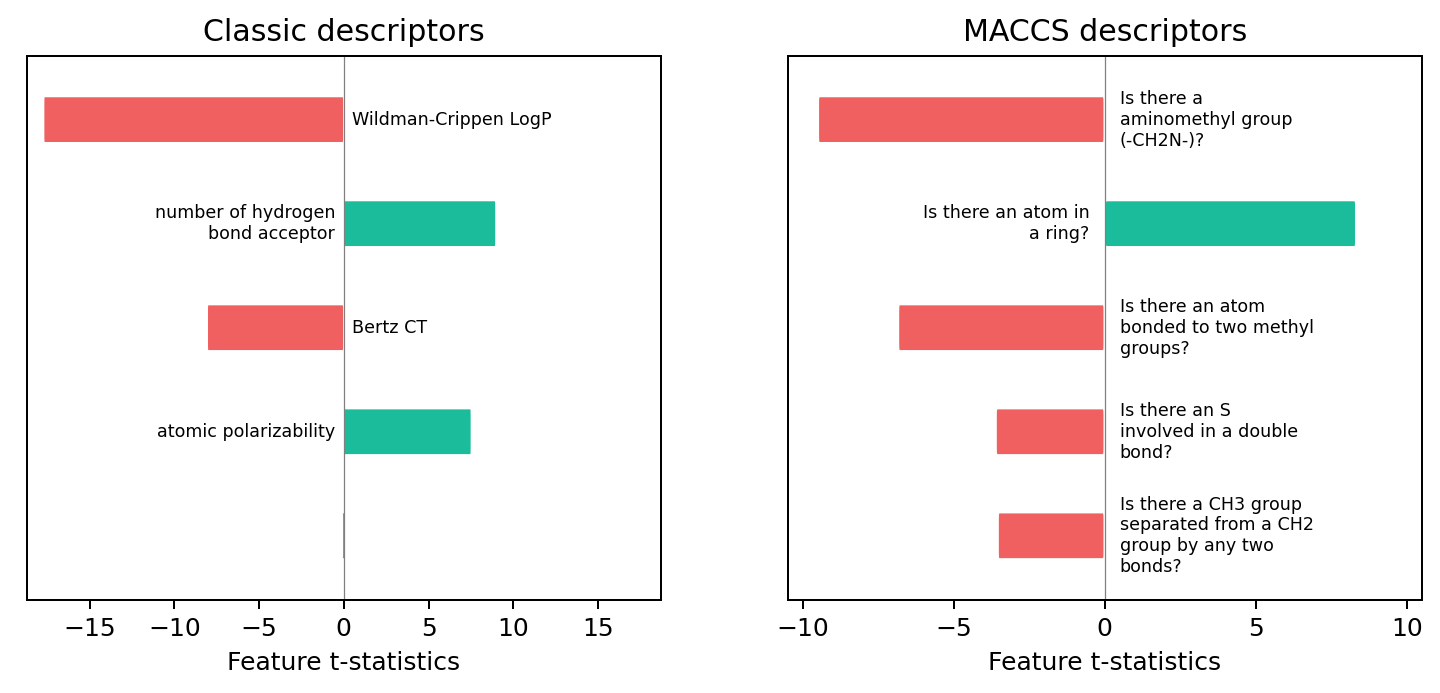

In [122]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
desc_type = ['Classic', 'MACCS']
fig, ax = plt.subplots(nrows=1, ncols=len(desc_type), figsize=(10,4), dpi=180, squeeze=True)
i=0
for d in desc_type:
    space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
    feature_importance = calc_ft_imp(space, space_tstats)
    if len(feature_importance.items()) > 5:
        feature_importance = {a:feature_importance[a] for a in list(feature_importance.keys())[:6]}
    plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'{d} descriptors')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
    i+=1
plt.savefig(f'desc.png', dpi=180, bbox_inches='tight', transparent=False)
plt.show()

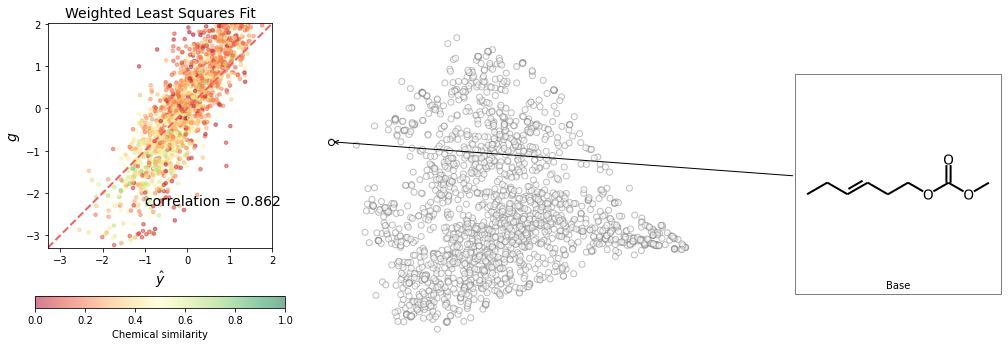

In [123]:
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

fig = plt.figure(figsize=(10,5))
ax_dict = fig.subplot_mosaic('AABBB')

svg = exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1, 
                       ax=ax_dict['B'], 
                       plot_by_fit=True, beta=beta)#, cartoon=True)

ys = [e.yhat for e in space]
ys -= np.mean(ys)
x_mat = np.array([list(e.descriptors.descriptors)
                  for e in space]).reshape(len(space), -1)
y_wls = x_mat @ beta

lower = np.min(ys)
higher = np.max(ys)

import matplotlib.colors as colors
col = np.array([e.similarity for e in space], dtype=float)
normalizer = plt.Normalize(min(col), max(col))
cmap = plt.get_cmap("RdYlGn")

ax_dict['A'].plot(np.linspace(lower, higher, 100), np.linspace(lower, higher, 100), '--', linewidth=2)
sc = ax_dict['A'].scatter(ys, y_wls, s=50, marker='.', alpha=0.5, c=col, cmap=cmap)
ax_dict['A'].text(max(ys) - 3, min(ys) + 1, f'correlation = {np.corrcoef(ys, y_wls)[0,1]:.3f}', fontsize=14)
# ax_dict['A'].text(max(ys) - 3, min(ys) - 1, f'loss = {np.sqrt(np.mean((ys - y_wls)**2)):.3f}', fontsize=14)
ax_dict['A'].set_xlabel(r'$\hat{y}$', fontsize=14)
ax_dict['A'].set_ylabel(r'$g$', fontsize=14)
ax_dict['A'].set_title('Weighted Least Squares Fit', fontsize=14)
ax_dict['A'].set_xlim(lower, higher)
ax_dict['A'].set_ylim(lower, higher)
ax_dict['A'].set_aspect(1.0/ax_dict['A'].get_data_ratio(), adjustable='box')
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.15, ax=ax_dict['A'])
cbar.set_label('Chemical similarity')
plt.tight_layout()
plt.savefig('Figure_1.svg', dpi=300, bbox_inches="tight", transparent=False)

In [22]:
np.corrcoef(ys,y_wls)

array([[1.        , 0.85880422],
       [0.85880422, 1.        ]])

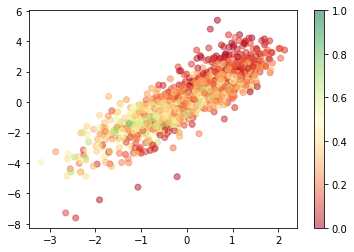

In [74]:
ax1 = plt.scatter(ys, y_wls, alpha=0.5, c=col, cmap=cmap)
plt.colorbar(ax1)

2.0624818667578088e-07


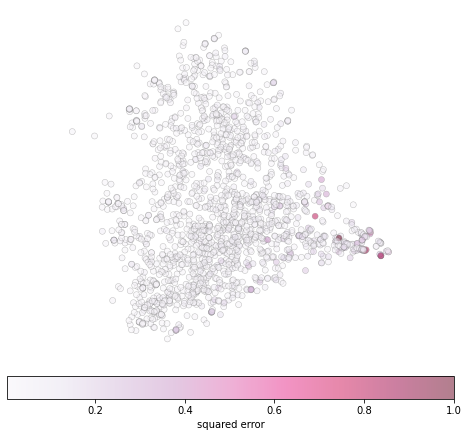

In [103]:
from matplotlib import cm

plt.figure(figsize=(8,8))

colors = (ys - y_wls)**2
space_x = [e.position[0] for e in space]
space_y = [e.position[1] for e in space]
print(min(colors))
normalizer = plt.Normalize(min(colors)-0.1, max(colors))
cmap = cm.get_cmap("PuRd")

im = plt.scatter(
            space_x,
            space_y,
            c=normalizer(colors),
            cmap=cmap,
            alpha=0.5,
            edgecolors="grey",
            linewidth=0.5
        )

plt.xticks([])
plt.yticks([])
plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
plt.gca().axis('off')
cbar = plt.colorbar(im, orientation="horizontal", pad=0.05)
cbar.set_label('squared error')

plt.savefig('colorbar.svg', dpi=180, bbox_inches='tight')

In [104]:
## Functions to highlight molecules by significant smarts

from IPython.display import SVG
from rdkit.Chem import MolFromSmarts, Mol
from rdkit.Chem.Draw import rdDepictor, MolDrawOptions, rdMolDraw2D, MolToImage as mol2img
from collections import defaultdict
from matplotlib import colors, cm

def get_significant_SMARTS(example, tstats):
    descriptors = list(example.descriptors.descriptors)
    descriptor_names = list(example.descriptors.descriptor_names)
    maccs_smarts = pd.read_csv('../exmol/MACCSkeys.txt', sep='\t')
#     descriptor_smarts = {a:b for a,b in zip(descriptor_names, maccs_smarts['SMARTS'])}
    desc_list = []
    for t, d, s in zip(tstats, descriptor_names, maccs_smarts['SMARTS']):
        if t > 2.96:
            desc_list.append([s, float(t)])
    return desc_list

def get_highlight_lists(smi, descriptor_list):
    print(smi)
    aidx, bidx = [], []
    arads = {}
    highlight_atoms = defaultdict(list)
    highlight_bonds = defaultdict(list)
    count = 0
    mol = MolFromSmiles(smi)
    rdDepictor.Compute2DCoords(mol)
    for t in descriptor_list:
        print(t[0])
        patt = MolFromSmarts(t[0])
        rdDepictor.Compute2DCoords(patt)

        que_mc = Mol(mol.ToBinary())  # make a copy of the Mol object
        matching = que_mc.GetSubstructMatches(patt)
        matching = [a for b in matching for a in b]
        aidx.append(matching)

        for a in matching:
            highlight_atoms[a].append(cmap(normalizer(t[1])))
            arads[a] = 0.2
        if len(matching) > 1:
            count += 1
        if count > 5:
            break
    return aidx, highlight_atoms, arads
    
def draw_with_highlights(smi, highlight_atoms, arads, name='test.svg'):
    d = rdMolDraw2D.MolDraw2DSVG(1000, 300)
    dos = MolDrawOptions()
    dos.useBWAtomPalette()
    dos.minFontSize = 10
    dos.atomHighlightsAreCircles = False
    dos.fillHighlights=True
    d.SetDrawOptions(dos)
    d.DrawMoleculeWithHighlights(MolFromSmiles(smi), '', dict(highlight_atoms), {}, arads, {})
    d.FinishDrawing()

    img = d.GetDrawingText()
    with open(name, 'w+') as f:
        f.write(img)
    
    return d

space_tstats, beta = exmol.lime_explain(space, descriptor_type='MACCS')
cfs = exmol.rcf_explain(space, nmols=5)

normalizer = colors.Normalize(min(space_tstats), max(space_tstats))
cmap = cm.seismic
imgs = []
for i, m in enumerate(cfs):
    tstats = list(m.descriptors.descriptors) * beta
    descriptor_list = get_significant_SMARTS(m, tstats)
    descriptor_list.sort(key=lambda x: x[1], reverse=True)
    aidx, highlight_atoms, arads = get_highlight_lists(m.smiles, descriptor_list)
    imgs.append(draw_with_highlights(m.smiles, highlight_atoms, arads, name=f'm{i}.svg'))

CCC=CCCOC(=O)OC
[R]
CCC=CCCOC(=S)OC
[R]
CCC=CCCOC(=O)OCCl
[R]
COC(=O)OCCC=CC[O-]
[R]
CNCC=CCCOC(=O)OC
[R]


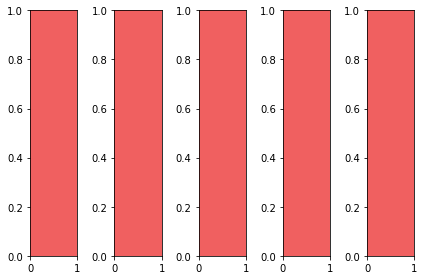

In [119]:
import skunk

fig, axs = plt.subplots(ncols=len(imgs))

# important line where we set ID
for i, im in enumerate(imgs):
    skunk.connect(axs[i], f'sk{i}')
    # Overwrite using file path to my svg
    # Can also use a string that contains the SVG 
    svg = skunk.insert(
        {
            f'sk{i}': f'm{i}.svg'
        })
plt.tight_layout()
skunk.display(svg)

# write to file
with open('replaced.png', 'w') as f:
    f.write(svg)
# or in jupyter notebook


In [60]:
# See if maccs keys are in the same order
maccs = pd.read_csv('../exmol/MACCSkeys.txt', sep='\t')
keys = maccs['KeyDescription']
example_descs = space[0].descriptors.descriptor_names

for k, ex in zip(keys, example_descs):
    print(k, ex)

Is it an ISOTOPE? Is it an ISOTOPE?
Is it Element 104 (Rf)? Is it Element 104 (Rf)?
Is it an element from Group IVa,Va,VIa Rows 4-6? Is it an element from Group IVa,Va,VIa Rows 4-6?
Is there an actinide? Is there an actinide?
Is it an element from Group IIIB,IVB (Sc...)? Is it an element from Group IIIB,IVB (Sc...)?
Is there a Lanthanide? Is there a Lanthanide?
Is it an element from Group VB,VIB,VIIB? Is it an element from Group VB,VIB,VIIB?
Is there a Heteroatom in a 4M ring? Is there a Heteroatom in a 4M ring?
Is it an element from Group VIII (Fe...)? Is it an element from Group VIII (Fe...)?
Is it an element from Group IIa (Alkaline earth)? Is it an element from Group IIa (Alkaline earth)?
Is there a 4M Ring? Is there a 4M Ring?
Is it an element from Group IB,IIB (Cu..)? Is it an element from Group IB,IIB (Cu..)?
Is there a Nitrone or aminoxyl group? Is there a Nitrone or aminoxyl group?
Is there a disulfide bond? Is there a disulfide bond?
Is there an orthoester or carbonate ester?

In [106]:
from rdkit.Chem import MolFromSmarts
smi = soldata.SMILES[100]
mol = MolFromSmiles(smi)
rdDepictor.Compute2DCoords(mol)

rdDepictor.Compute2DCoords(patt)

que_mc = Chem.Mol(mol.ToBinary())  # make a copy of the Mol object
matching = que_mc.GetSubstructMatch(patt)
que_mc

# matching = mol.GetSubstructMatch(patt)

NameError: name 'patt' is not defined

In [62]:
from rdkit.Chem.Draw import MolDrawOptions
from IPython.display import SVG

aidx, bidx = exmol.moldiff(mol, patt)

d = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(1000, 300)
dos = MolDrawOptions()
dos.useBWAtomPalette()
dos.minFontSize = 10
d.SetDrawOptions(dos)
d.DrawMolecule(mol, highlightAtoms=aidx,
               highlightBonds=bidx)
#                highlightAtomColors='cyan',
#                highlightBondColors='cyan')
d.FinishDrawing()
SVG(d.GetDrawingText())

img = d.GetDrawingText()
with open('test.svg', 'w+') as f:
    f.write(img)

NameError: name 'patt' is not defined

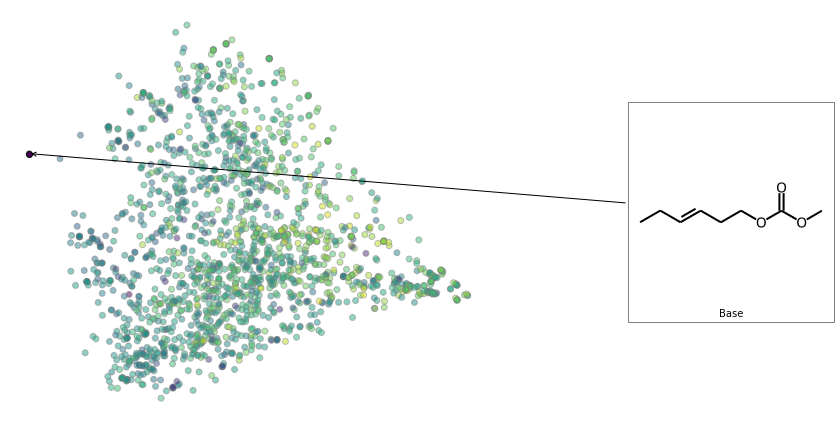

In [109]:
fkw = {'figsize': (7,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
svg = exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1) #, ax=ax_dict['B']) #, cartoon=True)
# plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('soldata1000.png', dpi=300, bbox_inches='tight')

In [133]:
from rdkit.Chem.Draw import MolToFile, MolToImage
MolToFile(MolFromSmiles(soldata.SMILES[500]), 'soldata500.svg', useSVG=True)

In [110]:
space[0].yhat

-1.4693719148635864

## Figure showing effect of mutation number, alphabet and size of chemical space


In [111]:
# Mutation

smi = soldata.SMILES[1000]
tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic':[], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
muts = [1,3,5]
for i in muts:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        spaces[d].append(space)    
        tstats[d].append(t)
#         print(tstats)
        beta[d].append(b)
#         print(beta)

🤘Done🤘: 100%|██████████| 673.0/673 [00:00<00:00, 1197.74it/s]                       
🤘Done🤘: 100%|██████████| 658.0/658 [00:00<00:00, 1117.58it/s]                       
🤘Done🤘: 100%|██████████| 1673.0/1673 [00:03<00:00, 533.48it/s]                      
🤘Done🤘: 100%|██████████| 1666.0/1666 [00:03<00:00, 524.43it/s]                      
🤘Done🤘: 100%|██████████| 1735.0/1735 [00:03<00:00, 527.99it/s]                      
🤘Done🤘: 100%|██████████| 1767.0/1767 [00:03<00:00, 474.97it/s]                      


(0.0, 1.0)


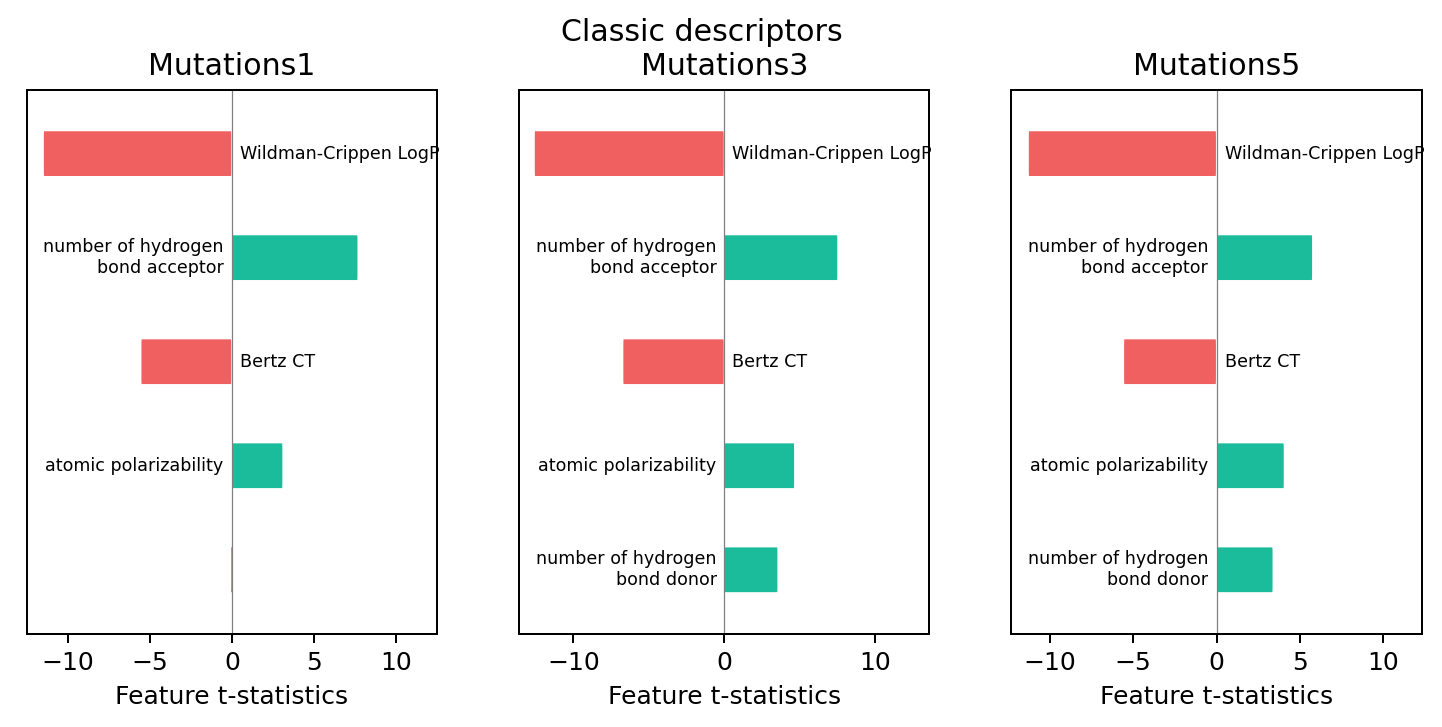

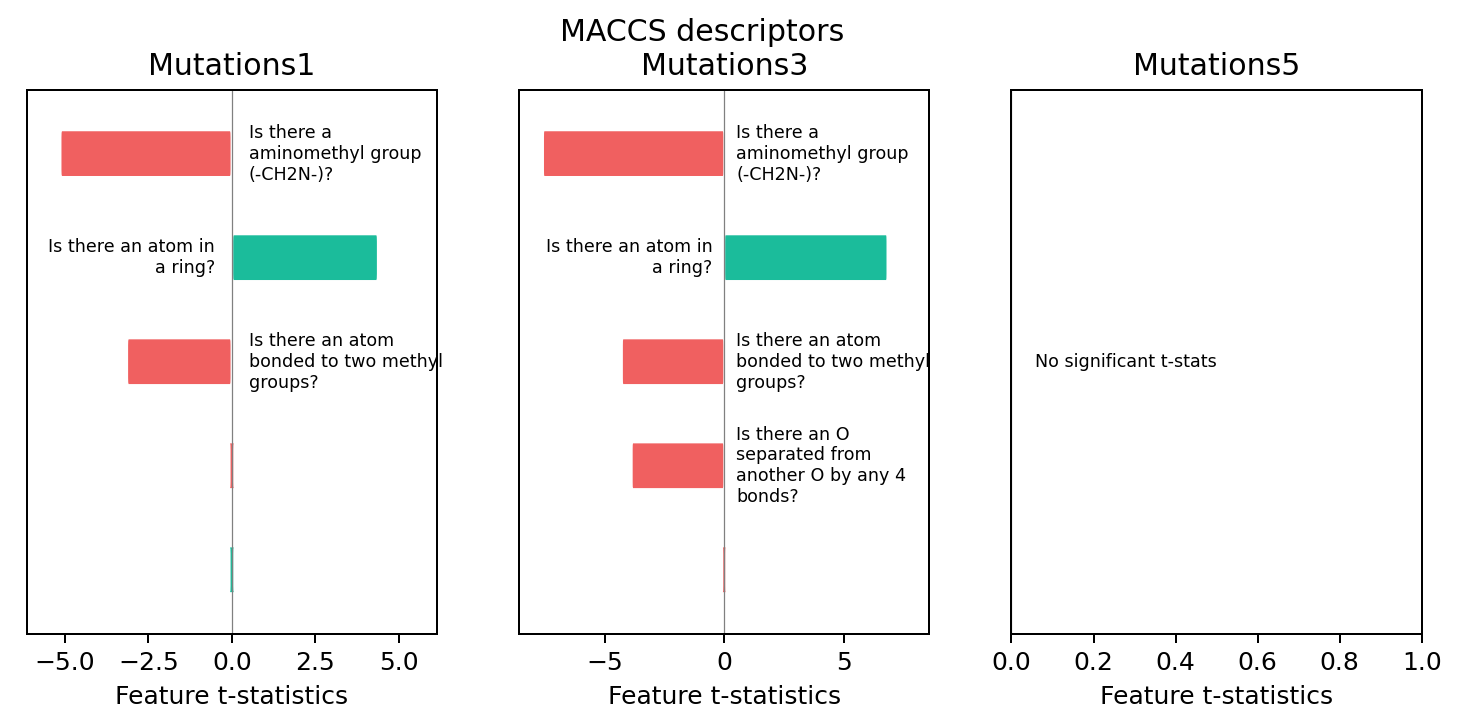

In [112]:

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Mutations{muts[i]}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_mutations.png', dpi=180, bbox_inches='tight')


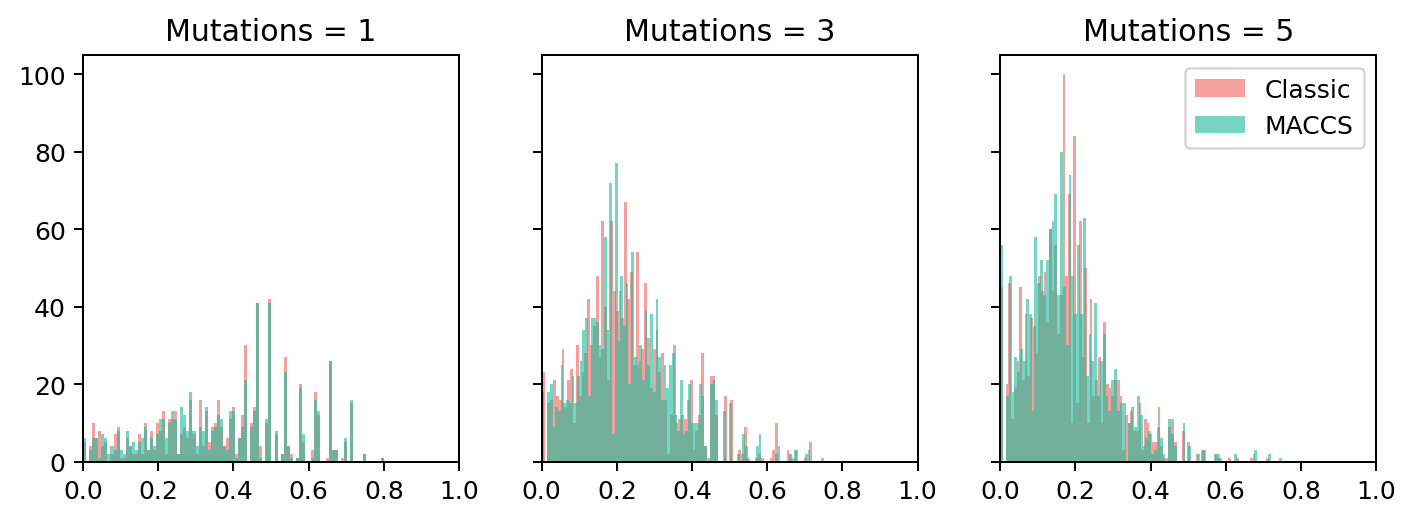

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
for i,n in enumerate([1,3,5]):
    for d in desc_type:
        axs[i].hist([e.similarity for e in spaces[d][i][1:]], bins=99, edgecolor='none', label=d, alpha=0.6)
        axs[i].set_title(f'Mutations = {n}')
        axs[i].set_xlim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

In [115]:
# Alphabet

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()
desc_type = ['Classic', 'MACCS']
alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

for a in alphs:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':alphs[a],'max_mutations':2}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)


🥌STONED🥌 Mutations: 2: 100%|██████████| 2500/2500 [00:00<00:00, 4057.41it/s]
🥌STONED🥌 Mutations: 2: : 5000it [00:01, 3146.19it/s]                        
🥌STONED🥌 Done: : 5000it [00:01, 3146.19it/s]        
😀Calling your model function😀: : 5000it [00:02, 3146.19it/s]
🔭Projecting...🔭:   0%|          | 0/1805 [00:00<?, ?it/s]              
🥰Finishing up🥰: 100%|██████████| 1805.0/1805 [00:03<00:00, 475.62it/s]
🤘Done🤘: 100%|██████████| 1805.0/1805 [00:03<00:00, 467.47it/s]        

🥌STONED🥌 Mutations: 2: 100%|██████████| 2500/2500 [00:00<00:00, 3950.99it/s]
🥌STONED🥌 Mutations: 2: : 5000it [00:01, 3135.17it/s]                        
🥌STONED🥌 Done: : 5000it [00:01, 3135.17it/s]        
😀Calling your model function😀: : 5000it [00:02, 3135.17it/s]
🔭Projecting...🔭:   0%|          | 0/1776 [00:00<?, ?it/s]              
🔭Projecting...🔭:  96%|█████████▌| 1699.5/1776 [00:00<00:00, 16992.50it/s]
🥰Finishing up🥰: 100%|██████████| 1776.0/1776 [00:03<00:00, 16992.50it/s] 
🤘Done🤘: 100%|██████████| 177

In [116]:
len(spaces['Classic'])

3

[15.50099528751229, -9.329124811001709, 9.284603698398987, 5.47777675593845, 3.8868573059438125]
[-10.07338349443291, 8.562571822153748, -6.575724688992481, -3.2813786403802214, -3.2580382370327747]
[-11.804059430968067, 11.48364744432603, -10.200845599684412, -9.492911170447993, -9.450226140116957]
[-13.83530127763137, -8.447126983504901, 5.837263772300212, -4.343703904767185, -3.956822889926741]


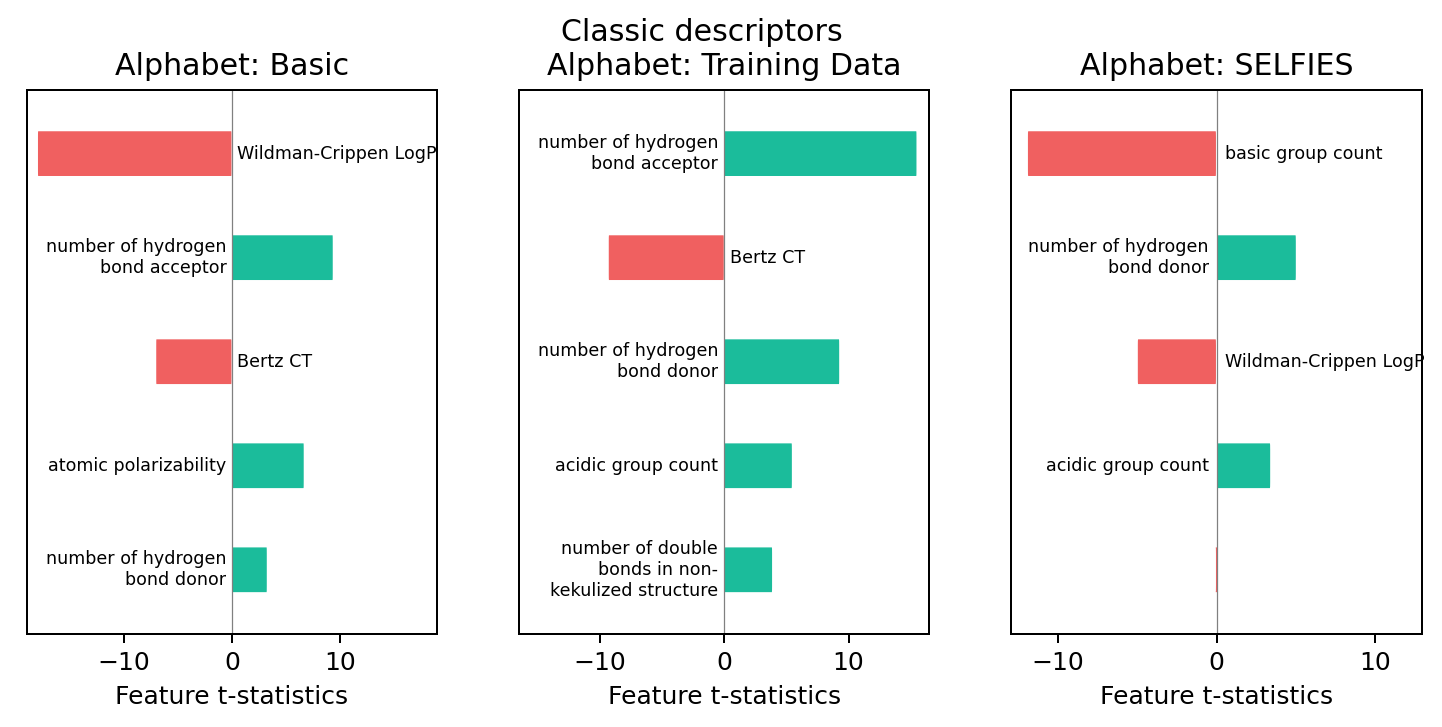

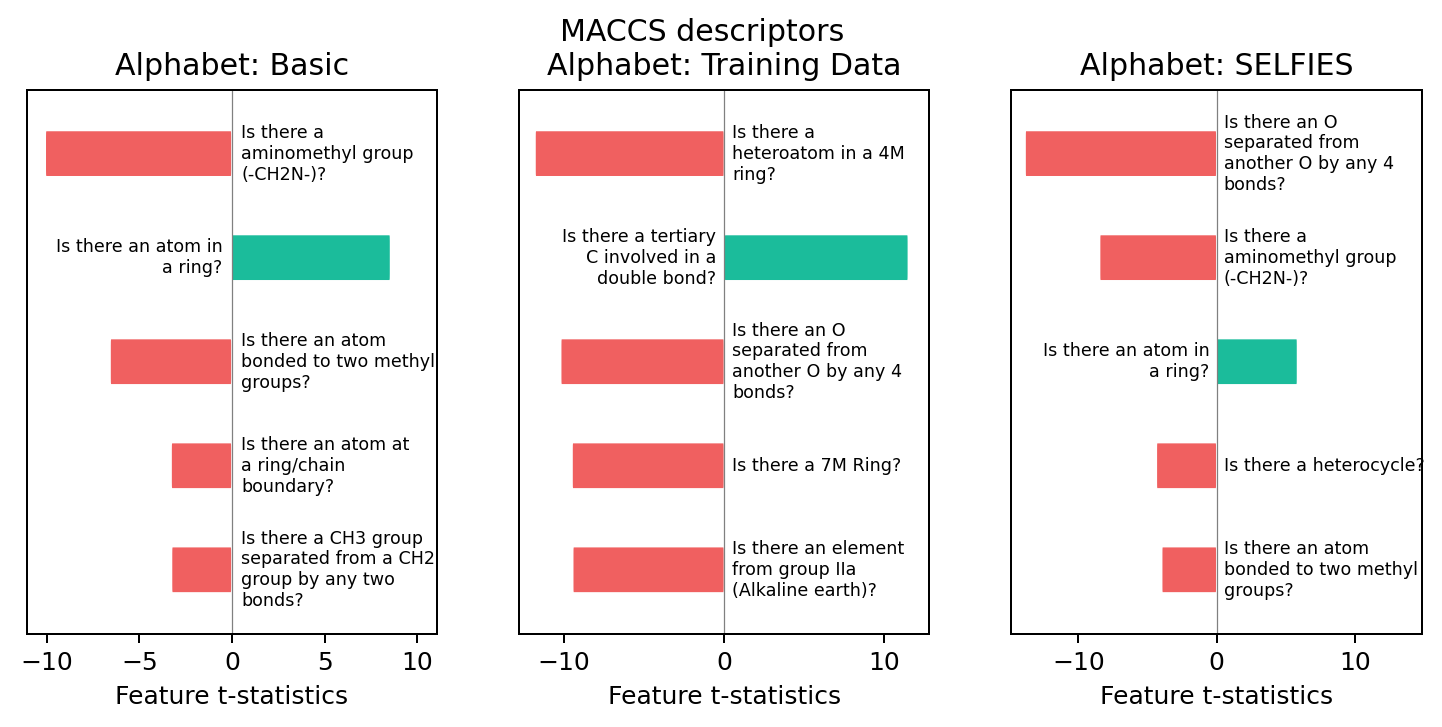

In [117]:
akeys = list(alphs.keys())

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Alphabet: {akeys[i]}')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_alphabet.png', dpi=180, bbox_inches='tight')


In [118]:
# Size of space

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
space_size = [1500, 2000, 2500]

for a in space_size:
    for d in desc_type:
        stoned_kwargs={'num_samples': a, 'alphabet': exmol.get_basic_alphabet(),'max_mutations':2}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)


🥌STONED🥌 Mutations: 2: 100%|██████████| 1500/1500 [00:00<00:00, 4276.62it/s]
🥌STONED🥌 Mutations: 2: : 3000it [00:00, 3239.82it/s]                        
🥌STONED🥌 Done: : 3000it [00:00, 3239.82it/s]        
😀Calling your model function😀: : 3000it [00:01, 3239.82it/s]
🔭Projecting...🔭:   0%|          | 0/1252 [00:00<?, ?it/s]              
🥰Finishing up🥰: 100%|██████████| 1252.0/1252 [00:01<00:00, 668.81it/s]
🤘Done🤘: 100%|██████████| 1252.0/1252 [00:01<00:00, 655.71it/s]        

🥌STONED🥌 Mutations: 2: 100%|██████████| 1500/1500 [00:00<00:00, 3423.34it/s]
🥌STONED🥌 Mutations: 2: : 3000it [00:01, 2837.32it/s]                        
🥌STONED🥌 Done: : 3000it [00:01, 2837.32it/s]        
😀Calling your model function😀: : 3000it [00:01, 2837.32it/s]
🔭Projecting...🔭:   0%|          | 0/1213 [00:00<?, ?it/s]              
🥰Finishing up🥰: 100%|██████████| 1213.0/1213 [00:01<00:00, 652.59it/s]
🤘Done🤘: 100%|██████████| 1213.0/1213 [00:01<00:00, 640.76it/s]        

🥌STONED🥌 Mutations: 2: 100%|█████

[-8.98421439165519, 7.6805095075583765, -3.9855586906333067, -3.4612922225776908, -3.440678012114469]
[-10.14979386589192, 6.818942962351737, -4.044558496306422, -3.8256612217984354, -3.5099725683229215]


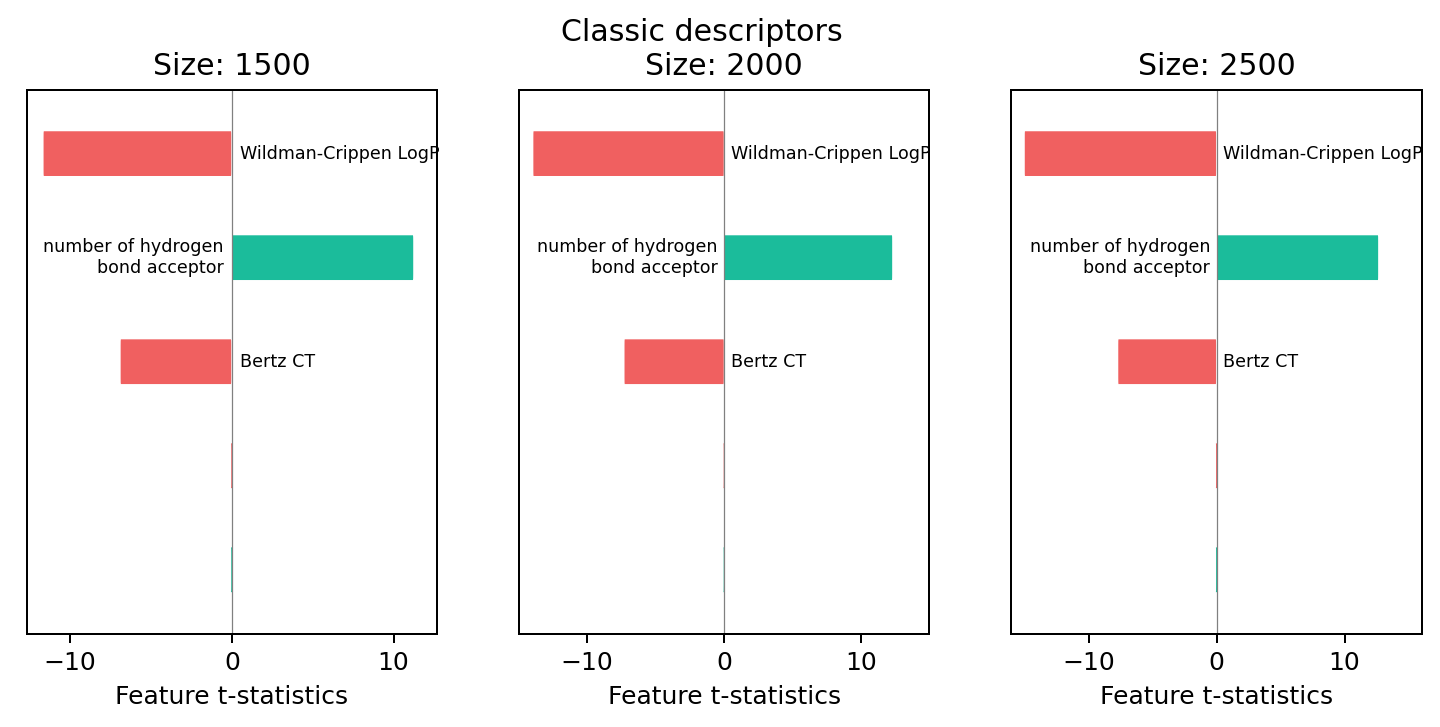

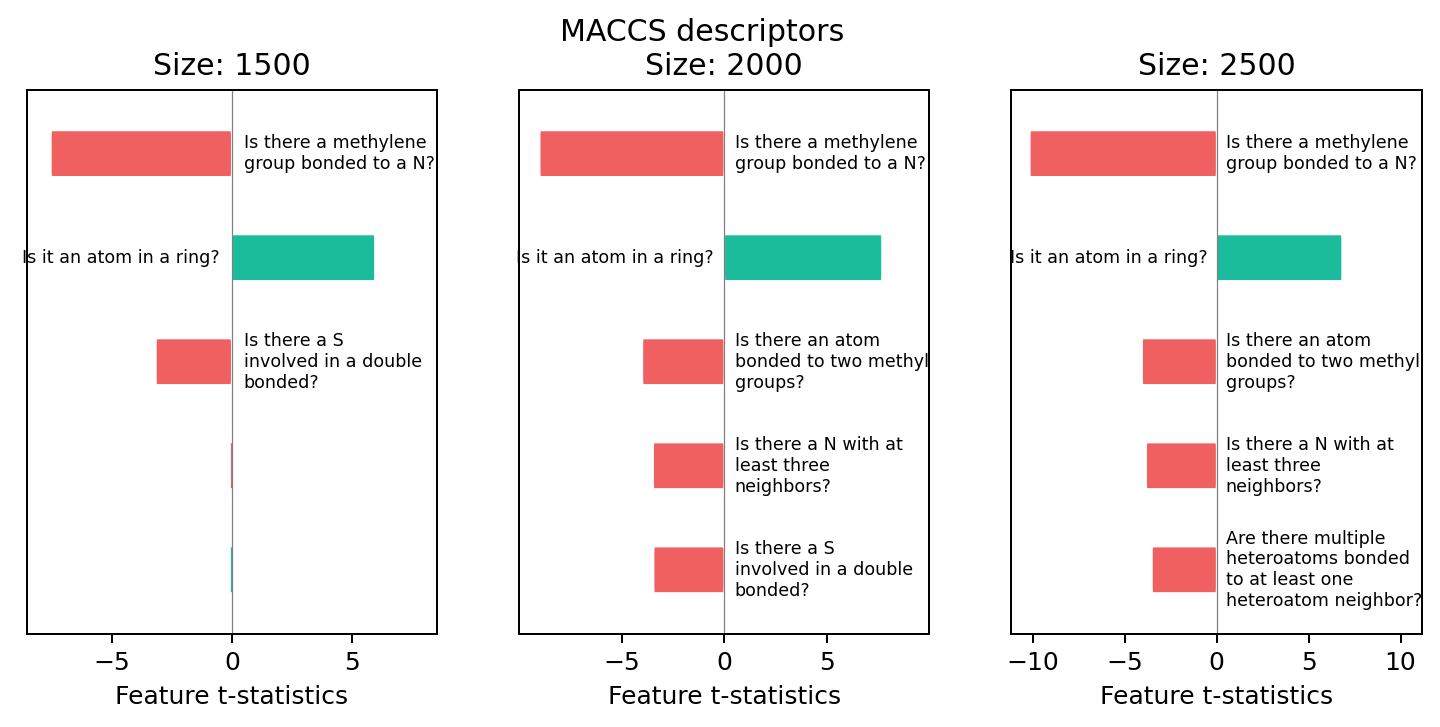

In [74]:
for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Size: {space_size[i]}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_size.png', dpi=180, bbox_inches='tight')

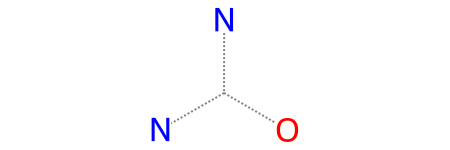

In [55]:
from rdkit.Chem import MolFromSmarts
mol = MolFromSmarts('[#7]~[#6](~[#8])~[#7]')
mol

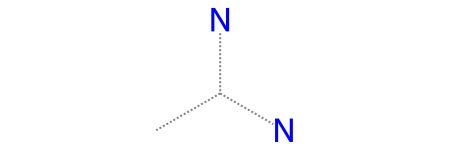

In [56]:
MolFromSmarts('[#7]~[#6](~[#6])~[#7]')

In [81]:
from rdkit.Chem.Draw import MolToFile 
MolToFile(mol, 'n_3.svg')

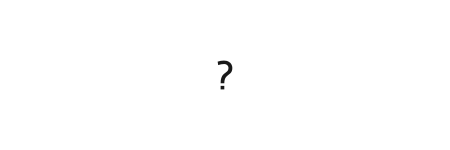

In [70]:
MolFromSmarts('[!#6;R]')